# Classification Modeling

- The question being asked in this project is if we can predict whether or not someone experiences food insecurity or not. Since this is a question with either a this or that answer, classification modeling will be used to get the predictions.
- The models that will be explored include Random Forest Classifier, Logistic Regression, Decision Trees, Bagging Decision Trees, and Support Vector Classifier.
- The goal will be to get a model that is not over or underfit as well as a modle that minimizes the false negatives. It is important to minimize false negatives because that would mean we are predicting people to be food secure when in actuality they are experiencing food insecurity. Wrongfully classifying those individuals would result in them not recieving the means necessary or having access to affordable foods and the goal of this project is to build a model that will allow for policy makers to allocate enough resources to households who experience food insecurity.

### Libraries and Data

In [1]:
from sklearn.experimental import enable_hist_gradient_boosting

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV 

from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, \
classification_report, plot_confusion_matrix

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, \
HistGradientBoostingClassifier

from sklearn.preprocessing import StandardScaler, PolynomialFeatures 

from category_encoders import TargetEncoder

from sklearn.decomposition import PCA

In [3]:
df = pd.read_csv('./data/cleaned_data.csv')

In [4]:
df.shape

(48870, 33)

In [5]:
df.head()

,HEFAMINC,HRNUMHOU,PRTAGE,PERET1,PEHRUSLT,PRNMCHLD,QSTNUM,HESP6,HESP7,HESP7A,...,race,marital_status,food_pantry,has_dis,service_status,job_loss,type_job,in_union,in_school,has_stamps
0,100000,4,30,0,60,2,1,0,0,0,...,White,yes,Unknown,No,No,No,ForProf,No,No,no
1,75000,3,20,0,40,1,2,0,0,0,...,White,yes,Unknown,No,No,No,ForProf,No,College,no
2,25000,3,20,0,0,1,5,0,0,2,...,White,yes,Yes,No,No,No,0,No,No,no
3,50000,1,20,0,40,0,6,0,0,0,...,Black,no,Yes,No,No,No,ForProf,No,No,no
4,150000,6,40,0,32,0,7,0,0,0,...,White,yes,Yes,No,No,No,Self-emp,No,No,no


### Last Data Cleaning Steps

- Since I had to covnert a lot of my columns back to their categorical values for data analysis, I will be taking some steps to convert back to numerical values for modeling below.
- Any column that has either yes or no values will be changed to values of 1 for yes and 0 for no.
- The other columns will either be dummified or target encoded based on the variables specific to the column.
- Dropping the column for household number identifier since we will not need that for modeling or the dataframe anymore because duplicates were dropped earlier.
- I will also be creating some interaction variables for modeling as well based on my findings in the EDA portion.

In [6]:
df.replace(['yes', 'no'], [1, 0], inplace=True)

In [7]:
df['is_metro'] = df['is_metro'].map({'Metro':1, 'No':0}) 

In [8]:
df['has_dis'] = df['has_dis'].map({'Yes':1, 'No':0})

In [9]:
df['in_school'] = df['in_school'].map({'College':1, 'HS':1, 'No':0})

In [10]:
df['in_union'] = df['in_union'].map({'Yes':1, 'No':0})

In [11]:
df['job_loss'] = df['job_loss'].map({'Lost':1, 'Quit':1, 'Temp':1, 'No':0})

In [12]:
df['service_status'] = df['service_status'].map({'Yes':1, 'No':0})

In [13]:
df['sex'] = df['sex'].map({'Male':1, 'Female':0})

In [14]:
df.drop('QSTNUM', axis=1, inplace=True)

In [15]:
#creating interaction variable between income and household numbers
df['income_people'] = df['HEFAMINC'] * df['HRNUMHOU'] 

In [16]:
df.head()

,HEFAMINC,HRNUMHOU,PRTAGE,PERET1,PEHRUSLT,PRNMCHLD,HESP6,HESP7,HESP7A,HESP8,...,marital_status,food_pantry,has_dis,service_status,job_loss,type_job,in_union,in_school,has_stamps,income_people
0,100000,4,30,0,60,2,0,0,0,0,...,1,Unknown,0,0,0,ForProf,0,0,0,400000
1,75000,3,20,0,40,1,0,0,0,0,...,1,Unknown,0,0,0,ForProf,0,1,0,225000
2,25000,3,20,0,0,1,0,0,2,2,...,1,Yes,0,0,0,0,0,0,0,75000
3,50000,1,20,0,40,0,0,0,0,2,...,0,Yes,0,0,0,ForProf,0,0,0,50000
4,150000,6,40,0,32,0,0,0,0,0,...,1,Yes,0,0,0,Self-emp,0,0,0,900000


### Pre Processing
- After reading this article about [target encoding](https://maxhalford.github.io/blog/target-encoding/) I took the advice to use this function so that I could target encode my variables before doing a train/test/split since using the target encode method requires a X and y training but no way to save it to the data frame. The function is based off of this equation which was also gathered from the article.
\begin{equation}
\mu = \frac{n \times \bar{x} + m \times w}{n + m}
\end{equation}

In [17]:
#target encoding categorical variables
# arguments needed are dataframe to reference, column to find mean by, 
    # target column to base mean on, and the weight which was recommended as 10
def target_encode(df, by, on, m):
    
    # getting mean from our target column
    mean = df[on].mean()
    
    #getting count of amount of values and the mean
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    n = agg['count']
    means = agg['mean']
    
    # calculating smooth means by multiplying the num of variables with the means 
     # adding that to the weighted mean and dividing by the sum of counts and weight
    smooth = (n * means + m * mean)/ (n + m)
    
    # using .map() to replace the old values with the target encoded mean values
    return df[by].map(smooth)

In [18]:
df['state'] = target_encode(df, 'state', 'food_secure', m=10)
df['region'] = target_encode(df, 'region', 'food_secure', m=10)
df['division'] = target_encode(df, 'division', 'food_secure', m=10)
df['education'] = target_encode(df, 'education', 'food_secure', m=10)
df['race'] = target_encode(df, 'race', 'food_secure', m=10)
df['food_pantry'] = target_encode(df, 'food_pantry', 'food_secure', m=10)
df['type_job'] = target_encode(df, 'type_job', 'food_secure', m=10)

#### Baseline Score

In [19]:
df['food_secure'].value_counts(normalize=True).mul(100).round(2)

0    82.14
1    17.86
Name: food_secure, dtype: float64

The baseline score tells us that there are 82% individuals who are food secure and 18% individuals who are food insecure.

In [20]:
#set up X and y variables
X = df.drop('food_secure', axis=1)

y = df['food_secure']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [22]:
#scaling data for the models that will need it
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

### Logistic Regression

In [23]:
#instantiate model
lr = LogisticRegression()

#fit model
lr.fit(X_train_sc, y_train)

LogisticRegression()

In [24]:
print(f"Score on training data: ", lr.score(X_train_sc, y_train))
print(f"Score on testing data: ", lr.score(X_test_sc, y_test))

Score on training data:  0.9374198277441818
Score on testing data:  0.937562003968254


In [25]:
y_preds = lr.predict(X_test_sc)

tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()

print(confusion_matrix(y_test, y_preds))

[[13118   130]
 [  877  2003]]


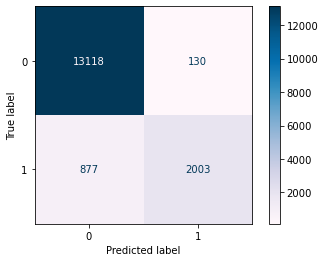

In [26]:
plot_confusion_matrix(lr, X_test_sc, y_test, cmap='PuBu');


In [27]:
lr_sens = tp / (tp + fn)

print(f"Sensitivity score: ", lr_sens)

Sensitivity score:  0.6954861111111111


In [28]:
lr_spec = tn / (tn + fn)

print(f"Specificity score: ", lr_spec)

Specificity score:  0.9373347624151482


In [29]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     13248
           1       0.94      0.70      0.80      2880

    accuracy                           0.94     16128
   macro avg       0.94      0.84      0.88     16128
weighted avg       0.94      0.94      0.93     16128



### Logistic Regression with PCA

In [30]:
pca = PCA(n_components=32, random_state=42)

pca.fit(X_train_sc)

Z_train = pca.transform(X_train_sc)
Z_test = pca.transform(X_test_sc)

In [31]:
logreg = LogisticRegression()

logreg.fit(Z_train, y_train)

print(f"Score on training data: ", lr.score(Z_train, y_train))
print(f"Score on testing data: ", lr.score(Z_test, y_test))

Score on training data:  0.8170850894875084
Score on testing data:  0.8200024801587301


In [32]:
pca_preds = logreg.predict(Z_test)

tn, fp, fn, tp = confusion_matrix(y_test, pca_preds).ravel()

print(confusion_matrix(y_test, pca_preds))

[[13118   130]
 [  877  2003]]


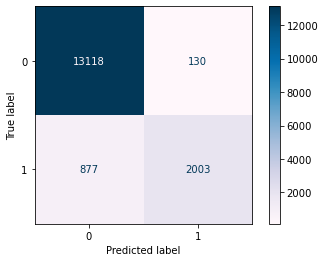

In [33]:
plot_confusion_matrix(logreg, Z_test, y_test, cmap='PuBu');

In [34]:
print(classification_report(y_test, pca_preds))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     13248
           1       0.94      0.70      0.80      2880

    accuracy                           0.94     16128
   macro avg       0.94      0.84      0.88     16128
weighted avg       0.94      0.94      0.93     16128



### Decision Tree Classifier

In [35]:
dtc = DecisionTreeClassifier()

dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [36]:
print(f'Score on training set: ', dtc.score(X_train, y_train))
print(f'Score on testing set: ', dtc.score(X_test, y_test))

Score on training set:  0.9993586219534543
Score on testing set:  0.919952876984127


In [37]:
# now running the decision tree through a gridsearch
params = {'max_depth': [5, 10, 15, 20, 25, 32],
          'min_samples_split': [5, 10, 15, 20],
          'min_samples_leaf': [2, 4, 6, 8, 10],
          'ccp_alpha': [0, 0.001, 0.01, 1, 10]}

In [38]:
dt_grid = GridSearchCV(DecisionTreeClassifier(),
                       params,
                       cv=5)

dt_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': [0, 0.001, 0.01, 1, 10],
                         'max_depth': [5, 10, 15, 20, 25, 32],
                         'min_samples_leaf': [2, 4, 6, 8, 10],
                         'min_samples_split': [5, 10, 15, 20]})

In [39]:
dt_grid.best_params_

{'ccp_alpha': 0,
 'max_depth': 10,
 'min_samples_leaf': 6,
 'min_samples_split': 15}

In [40]:
dt_grid.best_score_

0.9488119073796678

In [41]:
print(f'Score on training set: {dt_grid.score(X_train, y_train)}')
print(f'Score on testing set: {dt_grid.score(X_test, y_test)}')

Score on training set: 0.955714372976605
Score on testing set: 0.9471726190476191


In [42]:
dt_preds = dt_grid.predict(X_test)

In [43]:
tn, fp, fn, tp = confusion_matrix(y_test, dt_preds).ravel()

print(confusion_matrix(y_test, dt_preds))

[[13071   177]
 [  675  2205]]


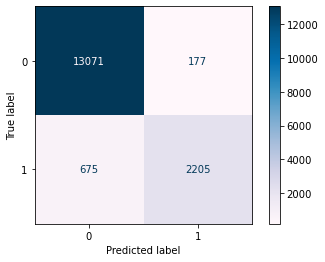

In [44]:
plot_confusion_matrix(dt_grid, X_test, y_test, cmap='PuBu');

In [45]:
dt_sens = tp / (tp + fn)

print(f"Sensitivity score: ", dt_sens)

Sensitivity score:  0.765625


In [46]:
dt_spec = tn / (tn + fn)

print(f"Specificity score: ", dt_spec)

Specificity score:  0.9508948057616762


In [47]:
print(classification_report(y_test, dt_preds))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     13248
           1       0.93      0.77      0.84      2880

    accuracy                           0.95     16128
   macro avg       0.94      0.88      0.90     16128
weighted avg       0.95      0.95      0.95     16128



### Bag of Trees

In [49]:
base_tree = DecisionTreeClassifier()

bag = BaggingClassifier(base_estimator=base_tree,
                        n_estimators=10,
                        bootstrap=True,
                        random_state=42)

In [50]:
bag.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=42)

In [51]:
print(f"Score on training data:", bag.score(X_train, y_train))
print(f"Score on testing data:", bag.score(X_test, y_test))

Score on training data: 0.9928837578645165
Score on testing data: 0.9463665674603174


In [52]:
bag_preds = bag.predict(X_test)

In [53]:
tn, fp, fn, tp = confusion_matrix(y_test, bag_preds).ravel()

print(confusion_matrix(y_test, bag_preds))

[[13017   231]
 [  634  2246]]


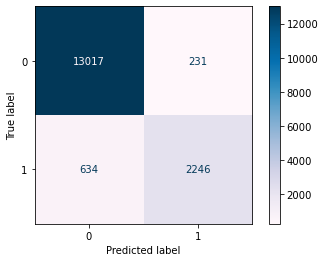

In [54]:
plot_confusion_matrix(bag, X_test, y_test, cmap='PuBu');

In [55]:
bag_sens = tp / (tp + fn)

print(f"Sensitivity score: ", bag_sens)

Sensitivity score:  0.7798611111111111


In [56]:
bag_spec = tn / (tn + fn)

print(f"Specificity score: ", bag_spec)

Specificity score:  0.9535565160061534


In [57]:
print(classification_report(y_test, bag_preds))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     13248
           1       0.91      0.78      0.84      2880

    accuracy                           0.95     16128
   macro avg       0.93      0.88      0.90     16128
weighted avg       0.95      0.95      0.94     16128



### Random Forest

In [58]:
rfc = RandomForestClassifier()

rfc.fit(X_train, y_train)

RandomForestClassifier()

In [59]:
print(f"Score on training data:", rfc.score(X_train, y_train))
print(f"Score on testing data:", rfc.score(X_test, y_test))

Score on training data: 0.999328080141714
Score on testing data: 0.9519469246031746


In [60]:
rfc_params = {'max_depth': [5, 10, 15, 20, 25, 32],
              'max_features': [5, 10, 15, 20, 25, 32],
              'min_samples_split': [5, 10, 15, 20]}

In [61]:
rf_grid = GridSearchCV(rfc,
                       rfc_params,
                       cv=5)

rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 15, 20, 25, 32],
                         'max_features': [5, 10, 15, 20, 25, 32],
                         'min_samples_split': [5, 10, 15, 20]})

In [62]:
rf_grid.best_params_

{'max_depth': 32, 'max_features': 10, 'min_samples_split': 15}

In [63]:
print(f"Score on training data:", rf_grid.score(X_train, y_train))
print(f"Score on testing data:", rf_grid.score(X_test, y_test))

Score on training data: 0.9675035123083501
Score on testing data: 0.9521949404761905


In [64]:
rf_preds = rf_grid.predict(X_test)

In [65]:
tn, fp, fn, tp = confusion_matrix(y_test, rf_preds).ravel()

print(confusion_matrix(y_test, rf_preds))

[[13087   161]
 [  610  2270]]


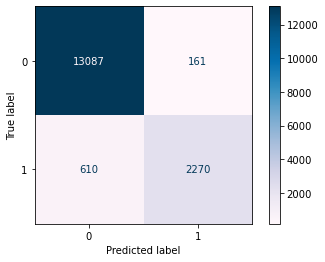

In [66]:
plot_confusion_matrix(rf_grid, X_test, y_test, cmap='PuBu');

In [67]:
rf_sens = tp / (tp + fn)

print(f"Sensitivity score: ", rf_sens)

Sensitivity score:  0.7881944444444444


In [68]:
rf_spec = tn / (tn + fn)

print(f"Specificity score: ", rf_spec)

Specificity score:  0.9554647002993356


In [69]:
print(classification_report(y_test, rf_preds))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     13248
           1       0.93      0.79      0.85      2880

    accuracy                           0.95     16128
   macro avg       0.94      0.89      0.91     16128
weighted avg       0.95      0.95      0.95     16128



### Support Vector Machine

In [70]:
from sklearn.svm import SVC

In [71]:
svc = SVC()

svc.fit(X_train_sc, y_train)

SVC()

In [72]:
print(f"Score on training set:", svc.score(X_train_sc, y_train))
print(f"Score on testing set:", svc.score(X_test_sc, y_test))

Score on training set: 0.953362653472604
Score on testing set: 0.9469246031746031


In [73]:
svc_preds = svc.predict(X_test_sc)

In [74]:
tn, fp, fn, tp = confusion_matrix(y_test, svc_preds).ravel()

print(confusion_matrix(y_test, svc_preds))

[[13120   128]
 [  728  2152]]


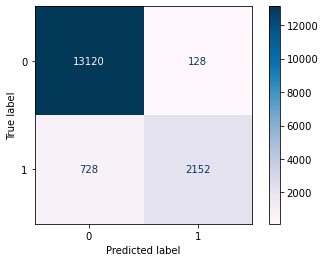

In [75]:
plot_confusion_matrix(svc, X_test_sc, y_test, cmap='PuBu');

In [76]:
print(classification_report(y_test, svc_preds))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     13248
           1       0.94      0.75      0.83      2880

    accuracy                           0.95     16128
   macro avg       0.95      0.87      0.90     16128
weighted avg       0.95      0.95      0.94     16128



### Gradient Boosting Classifier 

In [77]:
gbc = HistGradientBoostingClassifier()

gbc.fit(X_train, y_train)

HistGradientBoostingClassifier()

In [78]:
print(f"Score on training set:", gbc.score(X_train, y_train))
print(f"Score on testing set:", gbc.score(X_test, y_test))

Score on training set: 0.961547859018997
Score on testing set: 0.9521949404761905


In [79]:
gbc_preds = gbc.predict(X_test)

In [80]:
tn, fp, fn, tp = confusion_matrix(y_test, gbc_preds).ravel()

print(confusion_matrix(y_test, gbc_preds))

[[13101   147]
 [  624  2256]]


In [81]:
gbc.get_params()

{'early_stopping': 'auto',
 'l2_regularization': 0.0,
 'learning_rate': 0.1,
 'loss': 'auto',
 'max_bins': 255,
 'max_depth': None,
 'max_iter': 100,
 'max_leaf_nodes': 31,
 'min_samples_leaf': 20,
 'monotonic_cst': None,
 'n_iter_no_change': 10,
 'random_state': None,
 'scoring': 'loss',
 'tol': 1e-07,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [82]:
gbc_params = {'learning_rate': [0.001, 0.01, 0.1],
              'max_iter': [1000, 2000],
              'max_leaf_nodes': [10, 20, 32],
              'validation_fraction': [0.1, 0.2],
              'n_iter_no_change': [10, 15]}

In [83]:
gbc_grid = GridSearchCV(gbc,
                        gbc_params,
                        cv=5,
                        verbose=1)

gbc_grid.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 94.4min finished


GridSearchCV(cv=5, estimator=HistGradientBoostingClassifier(),
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_iter': [1000, 2000],
                         'max_leaf_nodes': [10, 20, 32],
                         'n_iter_no_change': [10, 15],
                         'validation_fraction': [0.1, 0.2]},
             verbose=1)

In [84]:
print(f"Score on training set:", gbc_grid.score(X_train, y_train))
print(f"Score on testing set:", gbc_grid.score(X_test, y_test))

Score on training set: 0.9554700384826827
Score on testing set: 0.9512648809523809


In [85]:
gbc2_preds = gbc_grid.predict(X_test)

In [86]:
tn, fp, fn, tp = confusion_matrix(y_test, gbc2_preds).ravel()

print(confusion_matrix(y_test, gbc2_preds))

[[13121   127]
 [  659  2221]]


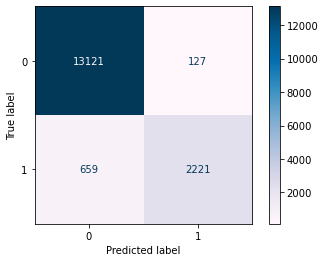

In [87]:
plot_confusion_matrix(gbc_grid, X_test, y_test, cmap='PuBu');

In [88]:
print(classification_report(y_test, gbc2_preds))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     13248
           1       0.95      0.77      0.85      2880

    accuracy                           0.95     16128
   macro avg       0.95      0.88      0.91     16128
weighted avg       0.95      0.95      0.95     16128

